In [1]:
this_state = 'ID'
this_state_name = 'Idaho'
idaho_crs_epsg = 8826    # https://idwr.idaho.gov/gis/idtm/

from ftplib import FTP
import os
import zipfile
import io
import pandas
import numpy as np
import time
import geopandas
from matplotlib import pyplot as plt
from IPython.display import display, HTML
from shapely.geometry import box
from shapely.ops import unary_union
import matplotlib.patches as mpatches

g = 0

show_water = True
show_roads = False
water_area_tol = 1 * 1000 * 1000

map_buffer_ratio = 0.05

print('ok')

ok


In [2]:
s = time.time()
script_dir = '/home/idies/workspace/Storage/raddick/jordanraddick.com/gerrymandering/'
census_script_dir = '/home/idies/workspace/Storage/raddick/census/'
basedir = '/home/idies/workspace/Temporary/raddick/census_scratch/redistricting/2020/'
shapefile_basedir = '/home/idies/workspace/Temporary/raddick/census_scratch/shapefiles/2020/'
extras_dir = '/home/idies/workspace/Storage/raddick/census/extras/'

official_new_districts_dir = '/home/idies/workspace/Temporary/raddick/census_scratch/redistricting/actual_new_districts/'


sandbox_dir = '/home/idies/workspace/Storage/raddick/jordanraddick.com/gerrymandering/sandbox/'
temp_sandbox_dir = '/home/idies/workspace/Temporary/raddick/census_scratch/redistricting/sandbox/'


district_color_cycle = ['blue', 'red', 'green', 'orange', 'cyan', 'yellow', 'pink', 'gray', 'lime', 'navajowhite', 'cornflowerblue', 'darkseagreen', 'thistle', 'tomato', 'silver', 'blueviolet', 'olive', 'peru', 'dodgerblue']
# district_color_cycle += district_color_cycle
# district_color_cycle += district_color_cycle

map_buffer_ratio = .1
print('ok')

ok


# Find districts and target population for this state

In [3]:
s = time.time()
print('Getting data from FTP...')

ftp = FTP('ftp2.census.gov')
ftp.login()
ftp.cwd('programs-surveys/decennial/2020/data/apportionment/')
for thisfile in [x for x in ftp.nlst() if x[-5:] == '.xlsx']:
    with io.open(sandbox_dir+'apportionment/'+thisfile, 'wb') as f:
        ftp.retrbinary('RETR {0:}'.format(thisfile), f.write)
ftp.quit()

e = time.time()
g += (e-s)
print('Got {0:.0f} apportionment Excel files in {1:.1f} seconds!'.format(len(os.listdir(sandbox_dir+'apportionment')), e-s))

s = time.time()
table1_df = pandas.read_excel(sandbox_dir+'apportionment/apportionment-2020-table01.xlsx', header=3)
table1_df = table1_df.rename(columns={'STATE': 'state_name'})
for thiscol in [x for x in table1_df.columns if '\n' in x]:
    table1_df = table1_df.rename(columns = {thiscol: thiscol.replace('\n', '')})
table1_df = table1_df.rename(columns = {'NUMBER OF APPORTIONED REPRESENTATIVES BASED ON 2020 CENSUS2': 'NUMBER OF APPORTIONED REPRESENTATIVES BASED ON 2020 CENSUS'})
table1_df = table1_df.head(len(table1_df)-2)
table1_df = table1_df.set_index('state_name')

table2_df = pandas.read_excel(sandbox_dir+'apportionment/apportionment-2020-table02.xlsx', header=3)
table2_df = table2_df.head(len(table2_df)-4)
table2_df = table2_df.drop('This cell is intentionally blank.', axis=1)
table2_df = table2_df.rename(columns={'AREA': 'state_name'})
table2_df = table2_df.set_index('state_name')

table3_df = pandas.read_excel(sandbox_dir+'apportionment/apportionment-2020-table03.xlsx', header=3)
table3_df = table3_df.head(len(table3_df)-2)
table3_df = table3_df.drop('This cell is intentionally blank.', axis=1)
table3_df = table3_df.rename(columns={'STATE': 'state_name'})
table3_df = table3_df.set_index('state_name')

#tablea_df = pandas.read_excel(sandbox_dir+'apportionment/apportionment-2020-tableA.xlsx')
#tableb_df = pandas.read_excel(sandbox_dir+'apportionment/apportionment-2020-tableB.xlsx')    # states considered for gaining and losing seats
#tablec1_df = pandas.read_excel(sandbox_dir+'apportionment/apportionment-2020-tableC1.xlsx')   # historic number of seats from 1910 to 2020
#tablec2_df = pandas.read_excel(sandbox_dir+'apportionment/apportionment-2020-tableC2.xlsx')   # historic population and seat changes from 1910 to 2020
#tabled_df = pandas.read_excel(sandbox_dir+'apportionment/apportionment-2020-tableD.xlsx')    # seats gained and lost in 2020 by state
#tablee_df = pandas.read_excel(sandbox_dir+'apportionment/apportionment-2020-tableE.xlsx')    # percent changes in population and rank of state thereby
#popchange_df = pandas.read_excel(sandbox_dir+'apportionment/population-change-data-table.xlsx')     # change in population by state and census region from decade to decade (1910-2020)
#popdensity_df = pandas.read_excel(sandbox_dir+'apportionment/population-density-data-table.xlsx')     # historic population density from 1910 to 2020

apportionment_df = pandas.read_excel(sandbox_dir+'apportionment/apportionment-data-table.xlsx', header=4)
apportionment_df = apportionment_df.rename(columns={'Unnamed: 0': 'state_name'})
apportionment_df = apportionment_df.drop([x for x in apportionment_df.columns if 'Unnamed' in x], axis=1)

for thiscol in [x for x in apportionment_df.columns if '\n' in x]:
    apportionment_df = apportionment_df.rename(columns = {thiscol: thiscol.replace('\n', ' (')+')'})
apportionment_df = apportionment_df.head(len(apportionment_df)-4)

apportionment_df = apportionment_df.set_index('state_name')

apportionment_df = apportionment_df.join(table1_df['APPORTIONMENT POPULATION (APRIL 1, 2020)'])
apportionment_df = apportionment_df[['APPORTIONMENT POPULATION (APRIL 1, 2020)'] + [x for x in apportionment_df if x != 'APPORTIONMENT POPULATION (APRIL 1, 2020)']]

apportionment_df = apportionment_df.join(table2_df['RESIDENT POPULATION (APRIL 1, 2020)'])

apportionment_df = apportionment_df.join(table3_df['OVERSEAS POPULATION (APRIL 1, 2020)'])

print('saving apportionment table...')
apportionment_df.to_csv(temp_sandbox_dir+'apportionment.csv')

nDistricts = int(apportionment_df.loc[this_state_name][[x for x in apportionment_df.columns if '2020' in x]]['Number of Seats 2020 Census'])
target_pop = int(apportionment_df.loc[this_state_name][[x for x in apportionment_df.columns if '2020' in x]]['Average Population Per Seat (2020 Census)'])

# apportionment_df.loc[:, 'nDistricts'] = pandas.to_numeric(apportionment_df['nDistricts'], downcast='integer', errors='coerce')
# apportionment_df.loc[:, 'target_pop'] = pandas.to_numeric(apportionment_df['target_pop'], downcast='integer', errors='coerce')


e = time.time()
g += (e-s)
print('Processed and saved apportionment data in {0:.1f} seconds!'.format(e-s))
print('\n')
print('{0:} has {1:,.0f} residents and {2:,.0f} overseas...'.format(this_state_name, apportionment_df.loc[this_state_name]['RESIDENT POPULATION (APRIL 1, 2020)'], apportionment_df.loc[this_state_name]['OVERSEAS POPULATION (APRIL 1, 2020)']))
print('\n')
print('{0:} now has {1:.0f} House districts, each with a target population of {2:,.0f}!'.format(this_state_name, nDistricts, target_pop))


Getting data from FTP...
Got 14 apportionment Excel files in 1.7 seconds!
saving apportionment table...
Processed and saved apportionment data in 0.3 seconds!


Idaho has 1,839,106 residents and 2,271 overseas...


Idaho now has 2 House districts, each with a target population of 920,689!


# Get redistricting data

In [4]:
s = time.time()
print('Getting data from FTP...')

ftp = FTP('ftp2.census.gov')
ftp.login()
print(ftp.getwelcome())

ftp.cwd('programs-surveys/decennial/2020/data/01-Redistricting_File--PL_94-171/{0:}'.format(this_state_name))
filename = '{0:}/{1:}'.format(temp_sandbox_dir, ftp.nlst()[0])
print('getting data...')
with io.open(filename, 'wb') as f:
    ftp.retrbinary('RETR {0:}'.format(ftp.nlst()[0]), f.write)
ftp.quit()

print('unzipping...')
os.chdir(temp_sandbox_dir)
for thisfile in [x for x in os.listdir(temp_sandbox_dir) if x[-4:] == '.zip']:
    print(temp_sandbox_dir+thisfile)
    with zipfile.ZipFile(temp_sandbox_dir+thisfile, 'r') as z:
        print('Extracting {0:}...'.format(thisfile))
        z.extractall()
for thisfile in [x for x in os.listdir() if ('zip' in x)]:
    os.remove(thisfile)
os.chdir(script_dir)

#os.getcwd()
e = time.time()
g += (e-s)
#print('Done in {0:.1f} seconds!'.format(e-s))
print('\n')
print('Retrieved and unzipped files from Census FTP in {0:,.1f} seconds!'.format(e-s))

Getting data from FTP...
220-    **WARNING**WARNING**WARNING**WARNING**WARNING****WARNING**WARNING**
220-
220-    This is a Census Bureau computer system. Census Bureau computer 
220-    systems are provided for the processing of official U.S. Government 
220-    information only. All data contained within Census Bureau computer 
220-    systems is owned by the Census Bureau, and may be monitored,intercepted, recorded, read, 
220-    copied, or captured in any manner and disclosed in any manner, by 
220-    authorized personnel. THERE IS NO RIGHT OF PRIVACY IN THIS SYSTEM. 
220-    System personnel may disclose any potential evidence of crime found 
220-    on Census Bureau computer systems to appropriate authorities. USE OF 
220-    THIS SYSTEM BY ANY USER, AUTHORIZED OR UNAUTHORIZED, CONSTITUTES 
220-    CONSENT TO THIS MONITORING, INTERCEPTION RECORDING, READING, COPYING, 
220-    CAPTURING, and DISCLOSURE OF COMPUTER ACTIVITY. Use of this computer 
220-    without authorization or 

## Get summary levels (so we can tell what units of analysis we are dealing with)

In [5]:
s = time.time()
print('setting up summary levels...')
sumlevel_df = pandas.read_excel(script_dir+'sumlevel.xlsx')
sumlevel_df = sumlevel_df.rename(columns={'sumlevel': 'SUMLEV'})
sumlevel_df.index.name = 'rownumber'
#sumlevel_df = sumlevel_df.set_index('SUMLEV')
e = time.time()
g += (e-s)
print('Read descriptions for {0:,.0f} summary levels in {1:.1f} seconds!'.format(len(sumlevel_df), e-s))
#sumlevel_df


setting up summary levels...
Read descriptions for 85 summary levels in 0.0 seconds!


## Read geo data (all levels)

In [6]:
s = time.time()
print('reading redistricting geography data for {0:}...'.format(this_state_name))

geofile = '{0:}{1:}geo2020.pl'.format(temp_sandbox_dir, this_state.lower())
geo_df = pandas.read_csv(geofile, sep='|', header=None, low_memory=False, encoding='ISO-8859-1')#, encoding='utf-8')

print('renaming columns...')
column_names = []
column_names += ['FILEID', 'STUSAB', 'SUMLEV', 'GEOVAR', 'GEOCOMP', 'CHARITER', 'CIFSN', 'LOGRECNO', 'GEOID']
column_names += ['GEOCODE', 'REGION', 'DIVISION', 'STATE', 'STATENS', 'COUNTY', 'COUNTYCC', 'COUNTYNS']
column_names += ['COUSUB', 'COUSUBCC', 'COUSUBNS']
column_names += ['SUBMCD', 'SUBMDCC', 'SUBMCDNS', 'ESTATE', 'ESTATECC', 'ESTATENS']
column_names += ['CONCIT', 'CONCITCC', 'CONCITNS', 'PLACE','PLACECC', 'PLACENS']
column_names += ['TRACT', 'BLKGRP', 'BLOCK']
column_names += ['AIANHH', 'AIANHHLI', 'AIANHHFP', 'AIANHHCC', 'AIANHHNS', 'AITS', 'AITSFP', 'AITSCC', 'AITSNS']
column_names += ['TTRACT', 'TBLKGRP', 'ANRC', 'ANRCCC', 'ARNCNS']
column_names += ['CBSA', 'MEMI', 'CSA', 'METDIV']
column_names += ['NECTA', 'NMEMI', 'CNECTA', 'NECTADIV']
column_names += ['CBSAPCI', 'NECTAPCI', 'UA', 'UATYPE', 'UR']
column_names += ['CD116', 'CD118', 'CD119', 'CD120', 'CD121']
column_names += ['SLDU18', 'SLDU22', 'SLDU24', 'SLDU26', 'SLDU28']
column_names += ['SLDL18', 'SLDL22', 'SLDL24', 'SLDL26', 'SLDL28']
column_names += ['VTD', 'VTDI', 'ZCTA', 'SDELM', 'SDSEC', 'SDUNI', 'PUMA']
column_names += ['AREALAND', 'AREAWATER', 'BASENAME', 'NAME', 'FUNCSTAT', 'GCUNI']
column_names += ['POP100', 'HU100']
column_names += ['INTPTLAT', 'INTPTLON', 'LSADC', 'PARTFLAG', 'UGA']
geo_df.columns = column_names

print('\tTotal columns: {0:.0f}'.format(len(geo_df.columns)))
print('\tNamed columns: {0:.0f}'.format(len(column_names)))

geo_df = geo_df.set_index('GEOID')

e = time.time()
g += (e-s)
print('\n')
print('Read {0:,.0f} geographies in {1:.0f} minutes {2:.0f} seconds!'.format(len(geo_df), np.floor((e-s)/60), (e-s)%60))
#geo_df

reading redistricting geography data for Idaho...
renaming columns...
	Total columns: 97
	Named columns: 97


Read 109,307 geographies in 0 minutes 4 seconds!


## Count units of analysis by summary level

In [7]:
s = time.time()
print('counting by summary level...')
count_df = pandas.DataFrame(data=None, columns=['sumlev_description', 'count', 'pop'], index=sumlevel_df['SUMLEV'].tolist())
count_df.index.name = 'SUMLEV'
count_df.loc[:, 'sumlev_description'] = sumlevel_df.set_index('SUMLEV')['description']
count_df.loc[:, 'count'] = geo_df.groupby('SUMLEV').size()
count_df.loc[:, 'pop'] = geo_df.groupby('SUMLEV')['POP100'].sum()
#count_df
nan_levels = count_df[count_df['count'].isnull()].index.tolist()

htmlstr = ''
htmlstr += '<table>'
htmlstr += '<tr>'
htmlstr += '<th>SUMLEVEL</th>'
for thiscol in count_df.columns.tolist():    
    htmlstr += '<th>{0:}</th>'.format(thiscol)
htmlstr += '</tr>'

for sumlev, thisrow in count_df.iterrows():
    #if ('remainder' not in thisrow['sumlev_description'].lower()):
    if (sumlev not in nan_levels):
        htmlstr += '<tr>'    
        htmlstr += '<td>{0:3d}</td><td>{1:}</td><td>{2:,.0f}</td><td>{3:,.0f}</td>'.format(sumlev, thisrow['sumlev_description'], thisrow['count'], thisrow['pop'])
        htmlstr += '</tr>'
htmlstr += '</table>'

# print('No data for these columns: {0:}'.format(nan_levels))
# display(HTML(htmlstr))

e = time.time()
g += (e-s)
print('\n')
print('Documented {0:,.0f} geographies in {1:.1f} seconds!'.format(len(count_df), e-s))


counting by summary level...


Documented 85 geographies in 0.1 seconds!


## Get 2010 Congressonal District data

In [8]:
s = time.time()
print('Getting current Congressional District data...')
cd_df = geo_df[geo_df['SUMLEV'] == 500]
cd_df = cd_df[cd_df['CD116'] != 'ZZ']
cd_df.loc[:, 'CD116'] = pandas.to_numeric(cd_df['CD116'], errors='coerce')
cd_df.loc[cd_df['CD116'] == 0, 'CD116'] = 1

print('adding shapefiles...')
gdf = geopandas.read_file(shapefile_basedir+'CD/tl_2020_us_cd116.shp')
gdf.loc[:, 'GEOID'] = gdf['GEOID'].apply(lambda x: '5001600US'+x)
gdf = gdf.set_index('GEOID')

cd_gdf = geopandas.GeoDataFrame(data=cd_df.join(gdf.geometry), crs=gdf.crs, geometry='geometry')
#cd_gdf

e = time.time()
g += (e-s)
print('\n')
print('Joined {0:,.0f} congressional districts to shapefiles in {1:.1f} seconds!'.format(len(cd_gdf), e-s))

#cd_gdf.plot()


Getting current Congressional District data...
adding shapefiles...


Joined 2 congressional districts to shapefiles in 2.4 seconds!


## Get census tract data

In [9]:
print('getting tract data...')
s = time.time()
tract_df = geo_df[geo_df['SUMLEV'] == 140]
tract_df = tract_df.assign(census_tract = tract_df['TRACT'].apply(lambda x: x/100))
#tract_df[['SUMLEV', 'STATE', 'STUSAB', 'COUNTY', 'census_tract', 'BLKGRP', 'NAME']].sample(3)

print('looking up state names from numbers...')
state_codes_df = pandas.read_csv(extras_dir+'statecodes.csv')
tract_df = tract_df.reset_index().merge(state_codes_df[['STATE', 'STATE_NAME']], how='left', on='STATE').set_index('GEOID')


print('looking up county names from numbers...')
county_names_df = pandas.read_excel(extras_dir+'all-geocodes-v2019.xlsx', header=4)
county_names_df = county_names_df[county_names_df['Summary Level'] == 50]
county_names_df = county_names_df.rename(columns={'State Code (FIPS)': 'STATE', 'County Code (FIPS)': 'COUNTY', 'Area Name (including legal/statistical area description)': 'COUNTY_NAME' })
county_names_df = county_names_df.reset_index(drop=True)
tract_df = tract_df.reset_index().merge(county_names_df[['STATE', 'COUNTY', 'COUNTY_NAME']], how='left', on=['STATE', 'COUNTY']).set_index('GEOID')

print('adding empty column for new districts...')
tract_df = tract_df.assign(new_district = np.nan)

print('adding shapefiles...')
gdf = geopandas.GeoDataFrame()
for this_state_key in tract_df['STATE'].drop_duplicates().tolist():
    print('\tgetting shapefiles for {0:}...'.format(state_codes_df[state_codes_df['STATE'] == this_state_key]['STUSAB'].values[0]))
    gdf_i = geopandas.read_file(shapefile_basedir+'TRACT/tl_2020_{0:02d}_tract.shp'.format(this_state_key))
    #print('\t\t{0:} CRS = {1:}'.format(this_state_key, gdf_i.crs))
    gdf = pandas.concat((gdf, gdf_i), axis=0)
gdf.loc[:, 'GEOID'] = gdf['GEOID'].apply(lambda x: '1400000US'+x)
gdf = gdf.set_index('GEOID')
tract_gdf = geopandas.GeoDataFrame(data=tract_df.join(gdf.geometry), crs=gdf.crs, geometry='geometry')


#state_codes_df
#tract_df = tract_gdf.reset_index().merge(state_codes_df[['STATE', 'STATE_NAME']], how='left', on='STATE').set_index('GEOID')

e = time.time()
g += (e-s)
print('\n')
print('Joined {0:,.0f} tracts to shapefiles in {1:.1f} seconds!'.format(len(tract_gdf), e-s))

#tract_gdf.plot()                       

getting tract data...
looking up state names from numbers...
looking up county names from numbers...
adding empty column for new districts...
adding shapefiles...
	getting shapefiles for ID...


Joined 456 tracts to shapefiles in 9.5 seconds!


## Get ancillary data for making plots

State, counties, water areas, metro areas, places, maybe roads

In [10]:
s = time.time()
state_numbers_include_list = cd_gdf['STATE'].drop_duplicates().tolist()
state_numbers_include_list = ['{0:02d}'.format(x) for x in state_numbers_include_list]
#state_numbers_include_list

print('getting state...')
state_gdf = geopandas.read_file(shapefile_basedir+'tl_2020_us_state.shp')
state_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(state_gdf['INTPTLON'])
state_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(state_gdf['INTPTLAT'])
state_gdf.loc[:, 'STATEFP'] = pandas.to_numeric(state_gdf['STATEFP'], errors='coerce')
state_gdf = state_gdf[state_gdf['STATEFP'].isin(state_numbers_include_list)]
state_gdf = state_gdf.set_index('GEOID')

print('getting counties...')
county_gdf = geopandas.read_file(shapefile_basedir+'tl_2020_us_county.shp')
county_gdf.loc[:, 'STATEFP'] = pandas.to_numeric(county_gdf['STATEFP'], errors='coerce')
county_gdf.loc[:, 'COUNTYNS'] = pandas.to_numeric(county_gdf['COUNTYNS'], errors='coerce')
county_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(county_gdf['INTPTLON'])
county_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(county_gdf['INTPTLAT'])
county_gdf = county_gdf[county_gdf['STATEFP'].isin(state_numbers_include_list)]
county_gdf = county_gdf.set_index('GEOID')


if (show_water):
    print('getting water areas...')

    waterfiles = [shapefile_basedir+'AREAWATER/'+x for x in os.listdir(shapefile_basedir+'AREAWATER/') if ((x[-4:] == '.shp') )]
    state_numbers_include_list = cd_gdf['STATE'].drop_duplicates().tolist()
    state_numbers_include_list = ['{0:02d}'.format(x) for x in state_numbers_include_list]

    waterfiles = [x for x in waterfiles if x[89:91] in state_numbers_include_list]

    water_gdf = geopandas.GeoDataFrame()

    for i in range(0, len(waterfiles)):
        if (np.mod(i, 10) == 0):
            print('\treading water file {0:,.0f} of {1:,.0f}...'.format(i, len(waterfiles)))
        water_gdf_i = geopandas.read_file(waterfiles[i])
        water_gdf_i = water_gdf_i[water_gdf_i['AWATER'] >= water_area_tol]
        water_gdf_i = water_gdf_i.assign(STUSAB = state_codes_df[state_codes_df['STATE'] == int(waterfiles[i][89:91])]['STUSAB'].values[0])
        water_gdf = pandas.concat((water_gdf, water_gdf_i), axis=0)
    water_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(water_gdf['INTPTLON'], errors='coerce')
    water_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(water_gdf['INTPTLAT'], errors='coerce')
    water_gdf = water_gdf.set_index('HYDROID')
    
    e = time.time()
    g += (e-s)

    print('Got {0:,.0f} water areas in {1:.0f} minutes {2:.1f} seconds!'.format(len(water_gdf), np.floor((e-s)/60), (e-s)%60))
    print('\n')


s = time.time()
print('getting CBSAs (metro areas)...')
cbsa_gdf = geopandas.read_file(shapefile_basedir+'CBSA/tl_2020_us_cbsa.shp')
cbsa_gdf = cbsa_gdf[cbsa_gdf['NAME'].apply(lambda x: this_state in x[x.find(',')+2:])]
cbsa_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(cbsa_gdf['INTPTLON'])
cbsa_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(cbsa_gdf['INTPTLAT'])
cbsa_gdf.loc[:, 'MEMI'] = pandas.to_numeric(cbsa_gdf['MEMI'])
cbsa_gdf = cbsa_gdf.set_index('GEOID')

print('\tClassifying CBSAs by type and spatial extent...')
cbsa_gdf = cbsa_gdf.assign(cbsa_type = np.nan)
cbsa_gdf.loc[cbsa_gdf['MEMI'] == 1, 'cbsa_type'] = 'metro'
cbsa_gdf.loc[cbsa_gdf['MEMI'] == 2, 'cbsa_type'] = 'micro'

cbsa_gdf = cbsa_gdf.assign(extends_beyond = False)
cbsa_gdf = cbsa_gdf.assign(extends_into = False)

cbsa_gdf.loc[
    (cbsa_gdf['NAME'].apply(lambda x: (len(x[x.find(',')+2:]) > 2)))
    & (cbsa_gdf['NAME'].apply(lambda x: x[x.find(',')+2:x.find(',')+4] == this_state)), 
    'extends_beyond'] = True


cbsa_gdf.loc[
    (cbsa_gdf['NAME'].apply(lambda x: (len(x[x.find(',')+2:]) > 2)))
    & (cbsa_gdf['NAME'].apply(lambda x: x[x.find(',')+2:x.find(',')+4] != this_state)), 
    'extends_into'] = True

print('\tFinding populations of CBSAs...')
cbsa_gdf = cbsa_gdf.assign(POP100 = np.nan)
for ix, thisrow in cbsa_gdf.iterrows():
    cbsa_gdf.loc[ix, 'POP100'] = tract_gdf[(tract_gdf['COUNTYNS'].isin(county_gdf[county_gdf.geometry.within(thisrow.geometry)]['COUNTYNS'].tolist()))]['POP100'].sum()
#     if (this_state in thisrow['NAME']):
#         print('\t\t{0:} (n = {1:,.0f})...'.format(thisrow['NAME'], cbsa_gdf.loc[ix]['POP100']))
cbsa_gdf.loc[cbsa_gdf[cbsa_gdf['POP100'] == 0].index.tolist(), 'POP100'] = np.nan

e = time.time()
g += (e-s)
print('Got {0:,.0f} CBSAs in {1:.1f} seconds!'.format(len(cbsa_gdf), e-s))
print('\n')
s = time.time()
print('getting places...')
placefiles = [shapefile_basedir+'PLACE/'+x for x in os.listdir(shapefile_basedir+'PLACE/') if ((x[-4:] == '.shp'))]
placefiles = [x for x in placefiles if x[85:87] in state_numbers_include_list]

place_gdf = geopandas.GeoDataFrame()

for i in range(0, len(placefiles)):
    if (np.mod(i, 5) == 0):
        print('\treading place file {0:,.0f} of {1:,.0f}...'.format(i, len(placefiles)))
    place_gdf_i = geopandas.read_file(placefiles[i])
    place_gdf = pandas.concat((place_gdf, place_gdf_i), axis=0)
place_gdf.loc[:, 'STATEFP'] = pandas.to_numeric(place_gdf['STATEFP'])
place_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(place_gdf['INTPTLON'])
place_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(place_gdf['INTPTLAT'])

place_gdf.loc[:, 'GEOID'] = place_gdf['GEOID'].apply(lambda x: '1600000US'+x)
place_gdf = place_gdf.set_index('GEOID')
e = time.time()
g += (e-s)
print('Got {0:,.0f} places in {1:.1f} seconds!'.format(len(place_gdf), e-s))
print('\n')

if (show_roads):
    s = time.time()
    print('getting roads...')
    roads_gdf = geopandas.GeoDataFrame()
    roads_file_list = [shapefile_basedir+'ROADS/'+x for x in os.listdir(shapefile_basedir+'ROADS/') if ((x[-4:] == '.shp') and (x[8:10] in state_numbers_include_list))]# and ('_{0:02d}'.format()))]# and ('tl_2018_{0:02d}'.format(this_state_number) in x))]
    for i in range(0, len(roads_file_list)):
        if ((np.mod(i,10) == 0) | (i == len(roads_file_list)-1)):
            print('\tReading road file {0:,.0f} of {1:,.0f}...'.format(i+1, len(roads_file_list)))
        roads_gdf_i = geopandas.read_file(roads_file_list[i])    
        roads_gdf = pandas.concat((roads_gdf, roads_gdf_i), axis=0, sort=False)
    roads_gdf = roads_gdf.set_index('LINEARID')
    e = time.time()
    g += (e-s)
    print('Got {0:,.0f} roads in {1:.0f} minutes {2:.1f} seconds!'.format(len(roads_gdf), np.floor((e-s)/60), (e-s)%60))
    print('\n')


print('Done!')

#cbsa_gdf[['NAME', 'MEMI', 'cbsa_type', 'extends_beyond', 'extends_into', 'POP100']].sort_values(by='POP100', ascending=False)



getting state...
getting counties...
getting water areas...
	reading water file 0 of 44...
	reading water file 10 of 44...
	reading water file 20 of 44...
	reading water file 30 of 44...
	reading water file 40 of 44...
Got 210 water areas in 0 minutes 14.4 seconds!


getting CBSAs (metro areas)...
	Classifying CBSAs by type and spatial extent...
	Finding populations of CBSAs...
Got 16 CBSAs in 2.7 seconds!


getting places...
	reading place file 0 of 1...
Got 237 places in 0.2 seconds!


Done!


# Assign each tract to its new district

In [11]:
s = time.time()
this_state = 'ID'

# nDistricts = these_states_dict[this_state]['seats_new']
# state_target = these_states_dict[this_state]['target']

print('creating new column for new district...')
tract_gdf = tract_gdf.assign(new_district = np.nan)

county_mapper_df = pandas.DataFrame(data=[    
    ['Ada County',1],
    ['Adams County',1],
    ['Boise County',1],
    ['Camas County',1],
    ['Canyon County',1],
    ['Elmore County',1],
    ['Gem County',1],
    ['Gooding County',1],
    ['Owyhee County',1],
    ['Payette County',1],
    #['Twin Falls County',1],
   ['Washington County',1],
], columns=['COUNTY_NAME', 'new_district_by_county'])


place_mapper_df = pandas.DataFrame(data=[
    #['Boise City',1]
    ['Twin Falls', 1]
], columns=['NAME', 'new_district_by_place'])

    
print('Assigning districts by county...')
tract_gdf.loc[tract_gdf[tract_gdf['STUSAB'] == this_state].index, 'new_district'] = tract_gdf[tract_gdf['STUSAB'] == this_state].reset_index().merge(county_mapper_df, how='left', on='COUNTY_NAME').set_index('GEOID')['new_district_by_county']



print('Assigning districts by place...')
place_mapper_gdf = geopandas.GeoDataFrame(place_mapper_df.merge(place_gdf.reset_index(), how='left', on='NAME')[['GEOID', 'NAME', 'new_district_by_place', 'geometry']].set_index('GEOID'))


print('\n')
for i in range(1, nDistricts+1):
    tracts_here = []
    tracts_within = tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()) & (tract_gdf.geometry.within(unary_union(place_mapper_gdf[place_mapper_gdf['new_district_by_place'] == i].geometry.tolist())))].index.tolist()
    tracts_here += tracts_within
    tracts_intersecting = tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()) 
              & (tract_gdf.geometry.intersects(unary_union(place_mapper_gdf.geometry.tolist())))
              & ~(tract_gdf.index.isin(tracts_within))
             ].index.tolist()
    for this_tract in tracts_intersecting:
        total_tract_area_geo = tract_gdf.loc[this_tract].geometry.area
        #total_tract_area_crs = tract_gdf.to_crs(equal_area_crs).loc[this_tract].geometry.area

        intersection_tract_area_geo = tract_gdf.loc[this_tract].geometry.intersection(unary_union(place_mapper_gdf[place_mapper_gdf['new_district_by_place'] == i].geometry.tolist())).area
        #intersection_tract_area_crs = tract_gdf.to_crs(equal_area_crs).loc[this_tract].geometry.intersection(unary_union(place_mapper_gdf.to_crs(equal_area_crs).geometry.tolist())).area
        
        intersection_tract_pct = intersection_tract_area_geo / total_tract_area_geo
        if (intersection_tract_pct >= 0.5):
            tracts_here.append(this_tract)
    tract_gdf.loc[tracts_here, 'new_district'] = i

    
print('Assigning districts by tract number...')
# tract_gdf.loc[['1400000US16083000300', '1400000US16083000400', '1400000US16083000500', '1400000US16083001600'], 'new_district'] = np.nan   # Twin Falls County but not city
# tract_gdf.loc[['1400000US16083000600', '1400000US16083001301', '1400000US16083001302'], 'new_district'] = np.nan   # Twin Falls County but not city
# tract_gdf.loc[['1400000US16083000701', '1400000US16083000900'], 'new_district'] = np.nan   # Twin Falls County but not city


tract_gdf.loc[['1400000US16083000300', '1400000US16083000400', '1400000US16083001600'], 'new_district'] = 1  # Twin Falls County but not city
tract_gdf.loc[['1400000US16083000600', '1400000US16083000701'], 'new_district'] = 1  




tract_gdf.loc[['1400000US16083001301', '1400000US16083001302'], 'new_district'] = 2   # Twin Falls County but not city
tract_gdf.loc[['1400000US16083000500', '1400000US16083000900'], 'new_district'] = 2   #  Twin Falls County but not city



# # print('All the rest are district 2...')
tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()), 'new_district'] = 2

# # print('Except ocean tracts...')
# # tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & tract_gdf.index.map(lambda x: x[-6:] == '990000'), 'new_district'] = np.nan

e = time.time()
g += (e-s)

print('Assigned districts to {0:,.0f} tracts in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(tract_gdf['new_district'].dropna()), np.floor((e-s)/60), (e-s)%60))
print('\n')

overseas_pop = apportionment_df.loc[this_state_name]['OVERSEAS POPULATION (APRIL 1, 2020)']
overseas_each_district = overseas_pop/2

overseas_adj = {}
overseas_adj[1] = np.floor(overseas_each_district)
overseas_adj[2] = np.ceil(overseas_each_district)

for i in range(1, nDistricts+1): 
    if (tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() > 0):

        print('District {0:}: n = {1:,.0f} ({2:.1%} of target; overshot = {3:,.0f})'.format(
            i, 
            (tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() + overseas_adj[i]), 
            (tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() + overseas_adj[i])/target_pop, 
            (tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() + overseas_adj[i]) - target_pop))


creating new column for new district...
Assigning districts by county...
Assigning districts by place...


Assigning districts by tract number...
Assigned districts to 456 tracts in 0 minutes 0 seconds!


District 1: n = 920,173 (99.9% of target; overshot = -516)
District 2: n = 921,204 (100.1% of target; overshot = 515)


# GET OFFICIAL NEW DISTRICTS

In [12]:
s = time.time()
# Downloaded from https://legislature.idaho.gov/redistricting/2021/#hcode-tab-style2adopted-plans

official_cd118_gdf = geopandas.read_file('{0:}/{1:}/C03.shp'.format(official_new_districts_dir, this_state_name.lower()))
official_cd118_gdf.loc[:, 'DISTRICT'] = pandas.to_numeric(official_cd118_gdf['DISTRICT'], downcast='integer', errors='coerce')
official_cd118_gdf = official_cd118_gdf.set_index('ID')

e = time.time()
g += (e-s)

print('Got {0:.0f} officially sanctioned new districts for {1:} in {2:,.1f} seconds!'.format(len(official_cd118_gdf), this_state_name, e-s))
# print(official_cd118_gdf.crs)
# print(place_gdf.crs)

Got 2 officially sanctioned new districts for Idaho in 0.1 seconds!


reprojecting...
plotting...
	District 1...
	District 2...
Plotted and saved in 7.4 seconds!


Total time: 66.1 seconds!


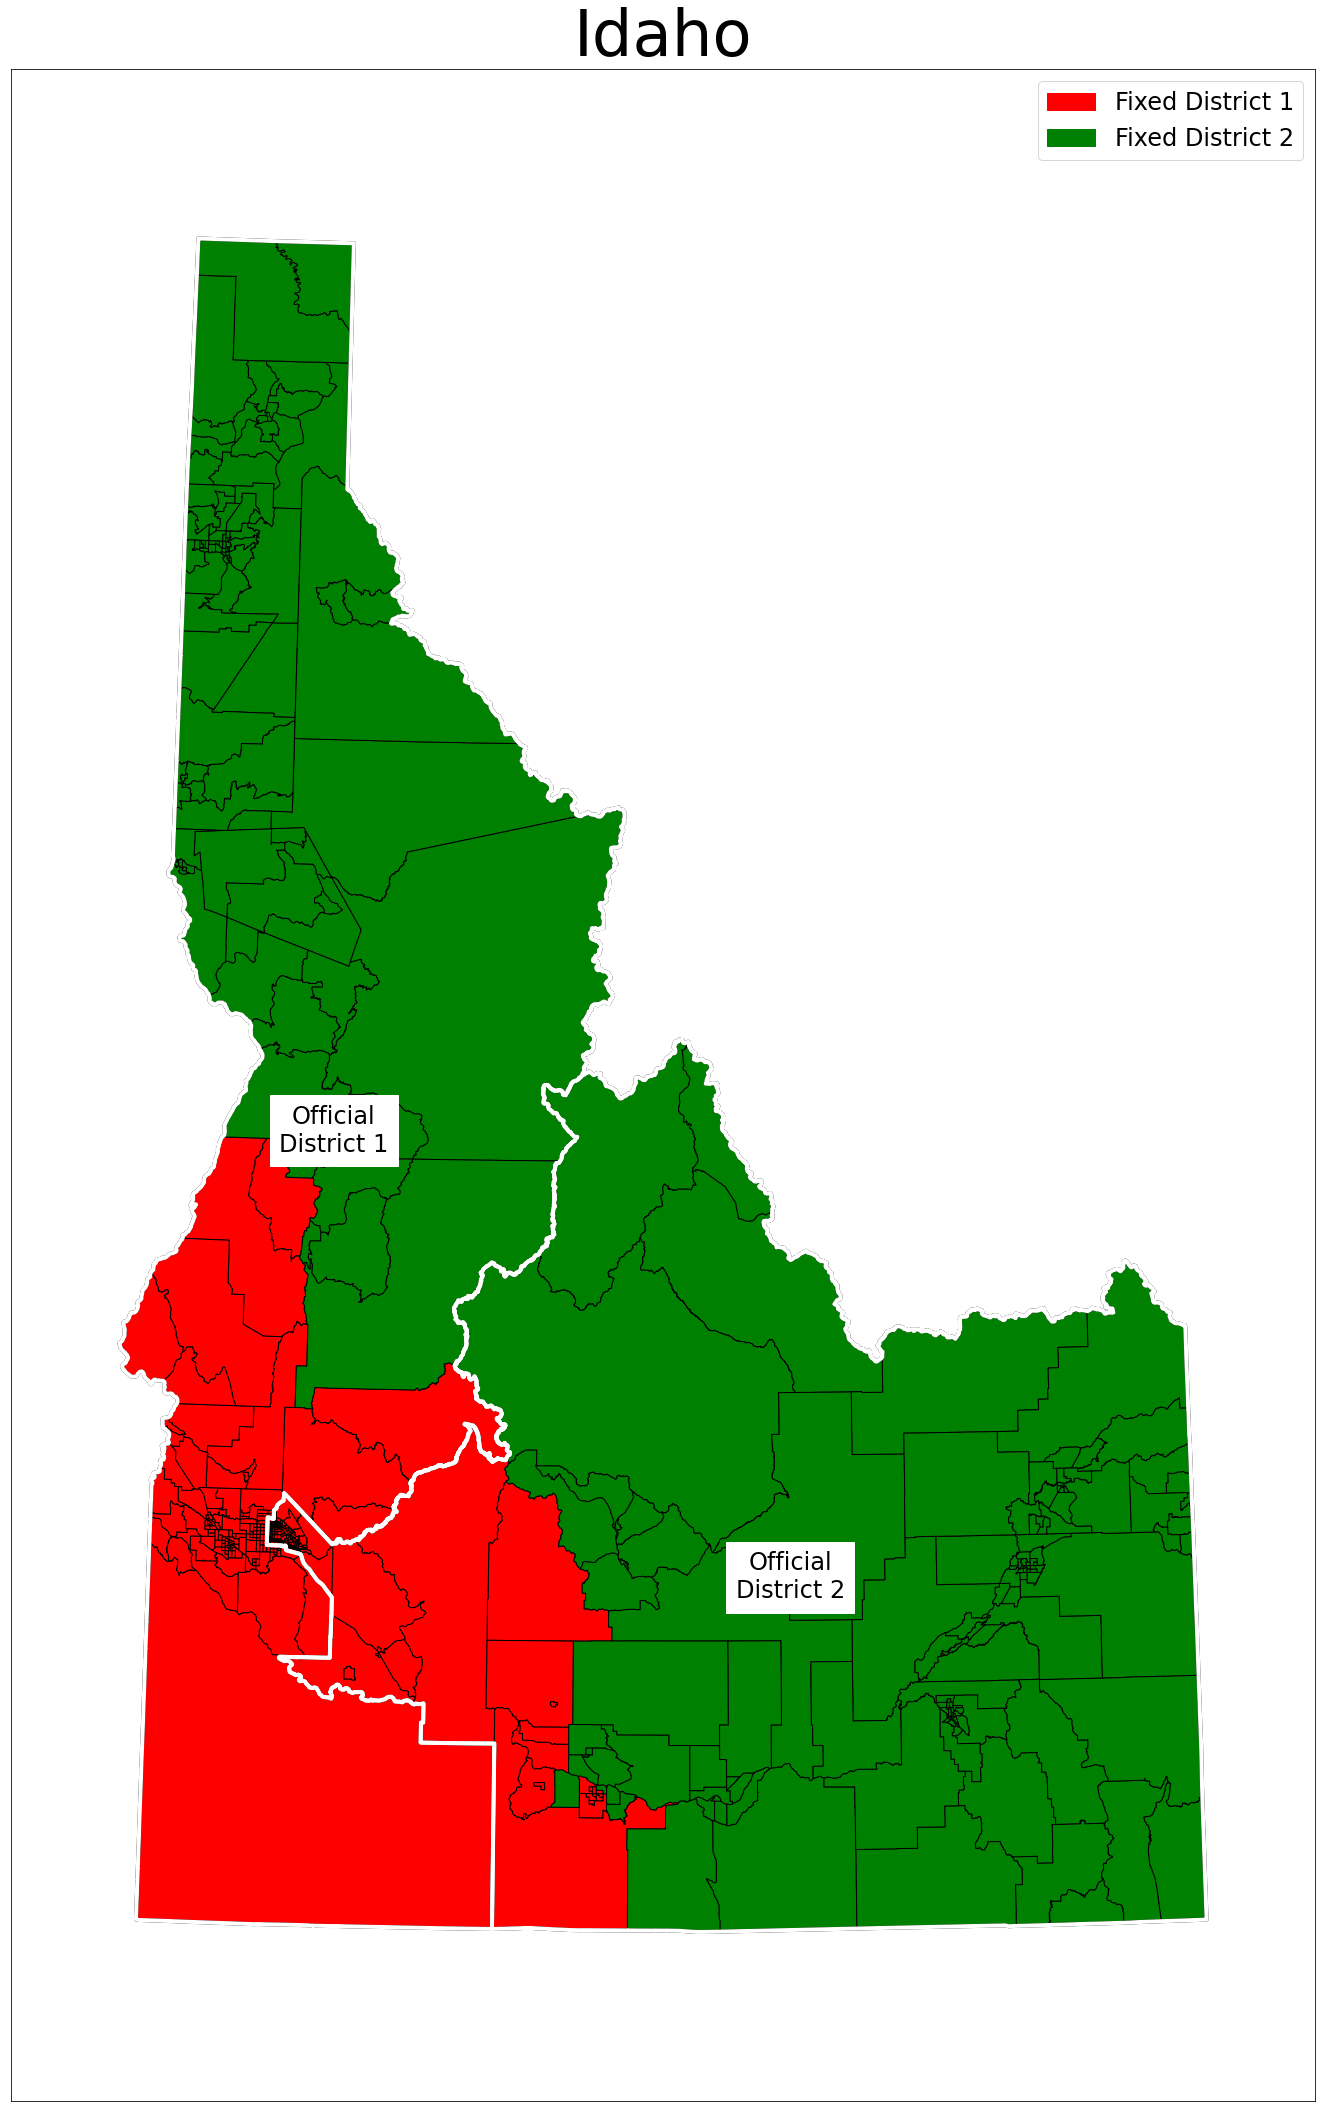

In [13]:
s = time.time()
show_places_mainmap = False
show_inset_places_mainmap = False
label_places = False

# print('setting up insets...')
# insets = {}
# insets['boise'] = {}
# insets['boise']['map_bounds'] = [place_gdf[(place_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) & (place_gdf['NAME'] == 'Boise City')].to_crs(epsg=idaho_crs_epsg).bounds['minx'].values[0], place_gdf[(place_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) & (place_gdf['NAME'] == 'Boise City')].to_crs(epsg=idaho_crs_epsg).bounds['miny'].values[0], place_gdf[(place_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) & (place_gdf['NAME'] == 'Boise City')].to_crs(epsg=idaho_crs_epsg).bounds['maxx'].values[0], place_gdf[(place_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) & (place_gdf['NAME'] == 'Boise City')].to_crs(epsg=idaho_crs_epsg).bounds['maxy'].values[0]]

# #insets['boise']['map_bounds'] = [2.305e6, 1.37e6, 2.345e6, 1.41e6]
# insets['boise']['axes_position'] = [0.65, 0.75]
# insets['boise']['axes_rel_size'] = .3
# insets['boise']['cityname'] = 'Boise City'
# insets['boise']['titlesize'] = 22
# insets['boise']['borderwidth'] = 3

# insets['twinfalls'] = {}
# insets['twinfalls']['map_bounds'] = [2.43e6, 1.245e6, 2.5e6, 1.28e6]
# insets['twinfalls']['axes_position'] = [0.65, 0.65]
# insets['twinfalls']['axes_rel_size'] = .3
# insets['twinfalls']['cityname'] = 'Twin Falls'
# insets['twinfalls']['titlesize'] = 22
# insets['twinfalls']['borderwidth'] = 3

# inset_cities_list = []
# for inset_name, this_inset in insets.items():
#     this_inset['aspect_ratio'] = (this_inset['map_bounds'][2] - this_inset['map_bounds'][0]) / (this_inset['map_bounds'][3] - this_inset['map_bounds'][1])
#     this_inset['axes_size'] = [this_inset['axes_rel_size'], this_inset['axes_rel_size'] / this_inset['aspect_ratio']]
#     inset_cities_list.append(this_inset['cityname'])

print('reprojecting...')
xlimits = [state_gdf[(state_gdf['STUSPS'] == this_state)].to_crs(epsg=idaho_crs_epsg).bounds['minx'].values[0], state_gdf[(state_gdf['STUSPS'] == this_state)].to_crs(epsg=idaho_crs_epsg).bounds['maxx'].values[0]]
ylimits = [state_gdf[(state_gdf['STUSPS'] == this_state)].to_crs(epsg=idaho_crs_epsg).bounds['miny'].values[0], state_gdf[(state_gdf['STUSPS'] == this_state)].to_crs(epsg=idaho_crs_epsg).bounds['maxy'].values[0]]

xspan = xlimits[1] - xlimits[0]
yspan = ylimits[1] - ylimits[0]
aspect_ratio = xspan / yspan

xlimits = [xlimits[0] - (xspan * map_buffer_ratio), xlimits[1] + (xspan * map_buffer_ratio)]
ylimits = [ylimits[0] - (yspan * map_buffer_ratio), ylimits[1] + (yspan * map_buffer_ratio)]

viewport_gdf = geopandas.GeoDataFrame(data=[[box(xlimits[0], ylimits[0], xlimits[1], ylimits[1])]], columns=['geometry'], crs=idaho_crs_epsg, geometry='geometry')

print('plotting...')
fig, ax = plt.subplots(1,1,figsize=(24, 24/aspect_ratio))
ax.set_aspect('equal')

new_district_list = tract_gdf[(tract_gdf['STUSAB'] == this_state)]['new_district'].drop_duplicates().sort_values().tolist()

legend_list = []
for i in range(1, len(new_district_list)+1):
    print('\tDistrict {0:.0f}...'.format(i))
    tract_gdf[
        (tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)
    ].to_crs(epsg=idaho_crs_epsg).plot(ax=ax, color=district_color_cycle[i], edgecolor='black')
    legend_list.append(mpatches.Patch(color=district_color_cycle[i], label='Fixed District {0:,.0f}'.format(i)))

geopandas.overlay(
    cd_gdf.reset_index().to_crs(epsg=idaho_crs_epsg),
    viewport_gdf, 
    how='intersection').set_index('GEOID').plot(ax=ax, color='none', edgecolor='black', lw=4)

geopandas.overlay(
    official_cd118_gdf.reset_index().to_crs(epsg=idaho_crs_epsg),
    viewport_gdf, 
    how='intersection').set_index('ID').plot(ax=ax, color='none', edgecolor='white', lw=4)
    

for ix, thisrow in geopandas.overlay(
    official_cd118_gdf.reset_index().to_crs(epsg=idaho_crs_epsg),
    viewport_gdf, 
    how='intersection'
).set_index('ID').iterrows():
    annotator = 'Official\nDistrict {0:.0f}'.format(thisrow['DISTRICT'])
    labelpoint = (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y)
    ax.annotate(annotator, labelpoint, 
                color='black', backgroundcolor='white', ha='center', va='center', fontsize=24)



if (show_places_mainmap):
    print('plotting places...')
    geopandas.overlay(
        place_gdf[
            (place_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0])
          ].reset_index().to_crs(epsg=idaho_crs_epsg),
        viewport_gdf, 
        how='intersection').set_index('GEOID').plot(ax=ax, color='none', edgecolor='yellow', lw=1)

    if (label_places):
        print('labeling places...')
        for ix, thisrow in geopandas.overlay(
            place_gdf[
                (place_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0])
              ].reset_index().to_crs(epsg=idaho_crs_epsg),
            viewport_gdf, 
            how='intersection').set_index('GEOID').iterrows():
            annotator = thisrow['NAME']
            labelpoint = (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y)
            ax.annotate(annotator, labelpoint, 
                        color='black', backgroundcolor='white', ha='center', va='center', fontsize=20)

if (show_inset_places_mainmap):
    print('plotting places that will appear in insets...')
    geopandas.overlay(
        place_gdf[
            (place_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0])
            & (place_gdf['NAME'].isin(inset_cities_list))
          ].reset_index().to_crs(epsg=idaho_crs_epsg),
        viewport_gdf, 
        how='intersection').set_index('GEOID').plot(ax=ax, color='none', edgecolor='yellow', lw=3)

ax.set_xlim(xlimits)
ax.set_ylim(ylimits)
ax.set_xticks([])
ax.set_yticks([])


# print('\n')
# for this_inset_name, this_inset in insets.items():
#     print('Plotting inset for {0:}...'.format(this_inset_name))
    
#     viewport_gdf = geopandas.GeoDataFrame(data=[[box(this_inset['map_bounds'][0], this_inset['map_bounds'][1], this_inset['map_bounds'][2], this_inset['map_bounds'][3])]], columns=['geometry'], crs=idaho_crs_epsg, geometry='geometry')

#     this_inset['axes'] = ax.inset_axes([this_inset['axes_position'][0], this_inset['axes_position'][1], this_inset['axes_size'][0], this_inset['axes_size'][1]])
    
#     this_inset['axes'].set_aspect('equal')
    
#     for i in range(1, len(new_district_list)+1):
#         print('\tDistrict {0:.0f}...'.format(i))
#         tract_gdf[
#             (tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)
#         ].to_crs(epsg=idaho_crs_epsg).plot(ax=this_inset['axes'], color=district_color_cycle[i], edgecolor='black')


#     geopandas.overlay(
#         place_gdf[
#             (place_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0])
#           ].reset_index().to_crs(epsg=idaho_crs_epsg),
#         viewport_gdf, 
#         how='intersection'
#     ).set_index('GEOID').plot(ax=this_inset['axes'], color='none', edgecolor='yellow', lw=1)
#     geopandas.overlay(
#         place_gdf[
#             (place_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0])
#             & (place_gdf['NAME'] == this_inset['cityname'])
#           ].reset_index().to_crs(epsg=idaho_crs_epsg),
#         viewport_gdf, 
#         how='intersection'
#     ).set_index('GEOID').plot(ax=this_inset['axes'], color='none', edgecolor='yellow', lw=3)
    
    
#     geopandas.overlay(
#         cd_gdf.reset_index().to_crs(epsg=idaho_crs_epsg),
#         viewport_gdf, 
#     how='intersection').set_index('GEOID').plot(ax=this_inset['axes'], color='none', edgecolor='black', lw=4)

#     geopandas.overlay(
#         official_cd118_gdf.reset_index().to_crs(epsg=idaho_crs_epsg),
#         viewport_gdf, 
#         how='intersection').set_index('ID').plot(ax=this_inset['axes'], color='none', edgecolor='white', lw=4)
    
    
#     if (this_inset_name != 'twinfalls'):
#         for ix, thisrow in geopandas.overlay(
#             official_cd118_gdf.reset_index().to_crs(epsg=idaho_crs_epsg),
#             viewport_gdf, 
#             how='intersection'
#         ).set_index('ID').iterrows():
#             annotator = 'Official\nDistrict {0:.0f}'.format(thisrow['DISTRICT'])
#             if (thisrow['DISTRICT'] == 1):
#                 labelpoint = (2.338e6, 1.402)
#             else:
#                 labelpoint = (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y)
#             this_inset['axes'].annotate(annotator, labelpoint, 
#                         color='black', backgroundcolor='white', ha='center', va='center', fontsize=16)    
    
#     this_inset['axes'].set_xlim(this_inset['map_bounds'][0], this_inset['map_bounds'][2])
#     this_inset['axes'].set_ylim(this_inset['map_bounds'][1], this_inset['map_bounds'][3])
    
#     if (this_inset['cityname'] == 'Boise City'):
#         this_inset['axes'].set_title('Boise', fontsize=this_inset['titlesize'])
#     elif (this_inset['cityname'] == 'Twin Falls'):
#         this_inset['axes'].set_title('Twin Falls (Legislated Distrct 2)', fontsize=this_inset['titlesize'])        
#     else:
#         this_inset['axes'].set_title(this_inset['cityname'], fontsize=this_inset['titlesize'])
#     print('\n')
# #     this_inset['axes'].set_xticks([])
# #     this_inset['axes'].set_yticks([])

ax.legend(handles=legend_list, fontsize=24, loc='upper right')
plt.title('Idaho', fontsize=64)

#plt.show()
fig.savefig(script_dir+'idaho.svg', format='svg', bbox_inches='tight')


e = time.time()
g += (e-s)

print('Plotted and saved in {0:,.1f} seconds!'.format(e-s))
print('\n')
print('Total time: {0:,.1f} seconds!'.format(g))



In [14]:
# print('setting up infrastructure to plot roads...')
# # we may derive from matplotlib.patches.BoxStyle._Base class.
# # You need to override transmute method in this case.
# class shield(BoxStyle._Base):
#     """
#     A simple box.
#     """

#     def __init__(self, pad=0.3):
#         """
#         The arguments need to be floating numbers and need to have
#         default values.

#          *pad*
#             amount of padding
#         """

#         self.pad = pad
#         super().__init__()

#     def transmute(self, x0, y0, width, height, mutation_size):
#         """
#         Given the location and size of the box, return the path of
#         the box around it.

#          - *x0*, *y0*, *width*, *height* : location and size of the box
#          - *mutation_size* : a reference scale for the mutation.

#         Often, the *mutation_size* is the font size of the text.
#         You don't need to worry about the rotation as it is
#         automatically taken care of.
#         """

#         # padding
#         pad = mutation_size * self.pad

#         # width and height with padding added.
#         width, height = width + 2.*pad, \
#                         height + 2.*pad,

#         # boundary of the padded box
#         x0, y0 = x0-pad, y0-pad,
#         x1, y1 = x0+width, y0 + height

#         cp = [(0.5*(x0+x1), (y0-2.*pad)), # bottom
#               (x1, y0),  # right lower-mid
#               (x1+pad, (y0+y1)/2.),  # far right mid
#               (x1, y1+pad),  # top right corner
#               ((x0+x1)/2,y1),  # dip from top
#               (x0, y1+pad),  # top left corner
#               (x0-pad, (y0+y1)/2.),    # far left mid
#               (x0, y0),  # left lower-mid
#               ((x0+x1)/2., (y0-2.*pad)),  # return to bottom
#               ((x0+x1)/2., (y0-2.*pad))]
        
        
#         com = [Path.MOVETO,  # start
#                Path.CURVE4, # curve to right mid
#                Path.LINETO,  # line to far right mid
#                Path.LINETO, # line to top right corner
#                Path.CURVE3,  # line to dip
#                Path.LINETO,  # line to top left corner
#                Path.CURVE4,   # curve to far left mid
#                Path.LINETO,   # line to left lower-mid
#                Path.LINETO,
#                Path.CLOSEPOLY]

#         path = Path(cp, com)

#         return path

# BoxStyle._style_list["shield"] = shield



# def parse_road_name(thename):
#     try:
#         annotator = thisrow['FULLNAME'][re.search('\d',thisrow['FULLNAME']).start():]
#     except AttributeError:
#         try: 
#             annotator = thisrow['FULLNAME'][re.search('Hwy',thisrow['FULLNAME']).end():]
#         except AttributeError:
#             annotator = thisrow['FULLNAME']
#     return annotator


# road_label_format = { 
#     'I': { 'labelsize': 16, 'thecolor': 'yellow', 'thebbox': dict(boxstyle="shield", fc='blue', ec='orange') },     
#     'U': { 'labelsize': 14, 'thecolor': 'black', 'thebbox': dict(boxstyle="shield", fc='white', ec='black') },
#     'S': { 'labelsize': 12, 'thecolor': 'black', 'thebbox': dict(boxstyle="square,pad=0.25", fc='white', ec='black')},
#     'C': { 'labelsize': 10, 'thecolor': 'black', 'thebbox': dict(boxstyle="sawtooth,pad=0.5", fc='white') }, 
#     'M': { 'labelsize': 16, 'thecolor': 'black'},
#     'O': { 'labelsize': 11, 'thecolor': 'yellow' }
# }
# print('Done!')



In [15]:
# s = time.time()
# tract_gdf['new_district'].to_csv(script_dir+'new-districts-1-to-7.csv')
# e = time.time()
# g += (e-s)
# print('Classified and saved {0:,.0f} in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(tract_gdf), np.floor((e-s)/60), (e-s)%60))
# print('\n')
# print('TOTAL TIME: {0:,.0f} minutes {1:,.0f} seconds!'.format( np.floor(g/60), g%60))